# In this notebook, frame properties are assigned to entities detected in the Entity identification section
 

In [2]:
from collections import defaultdict
import nltk
import os
import pickle
import stanza
import re
import pandas as pd
from  tqdm.notebook import tqdm


nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

def pickle_file(file_name, file_to_dump):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path +  fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, 'wb') as fp:
        pickle.dump(file_to_dump, fp)

def load_pickle(file_name):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path + fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)
    
def read_event_df(event_name):
    data_url = fr"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_{event_name}_clean.csv"
    directory_path = os.getcwd() + "/../../../../" + data_url 
    event_df = pd.read_csv(directory_path, index_col=0)
    event_df.reset_index(drop=True, inplace=True)
    print(f'loaded {event_df.shape[0]} tweets!')
    return event_df


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikodemicek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Encoding the vocabulary of the event dataset

Pre-requisite files:
     
     -event_df = event dataset (specifically, frame identification corpus)
     
The word embeddings created in this step will be used to determine the similarity of words in the vocabulary to frames' seed words

In [3]:
def get_bag_of_words(df_col):
    
    df_col = df_col[~df_col.isnull()] 
    df_col = df_col.apply(lambda x: x.split(' '))     
    bag_of_words = set([word for tweet_words in df_col for word in tweet_words if len(word)>1])

    return list(bag_of_words)


def embed_words(bag_of_words):
    from time import time
    from sentence_transformers import SentenceTransformer
    #sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    sbert_model = SentenceTransformer('paraphrase-mpnet-base-v2')

    print(f'there are {len(bag_of_words)} entities to be encoded')
    t0 = time()
    word_embeddings = sbert_model.encode(bag_of_words)
    print(f'Training embeddings took {time()-t0} seconds')
    return word_embeddings

In [14]:
event_df = read_event_df('greece')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('greece_word_embeddings',model)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
event_df = read_event_df('channel')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('channel_word_embeddings',model)

In [ ]:
event_df = read_event_df('tigray')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('tigray_word_embeddings',model)

In [ ]:
event_df = read_event_df('rohingya')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('rohingya_word_embeddings',model)

In [ ]:
event_df = read_event_df('afghanistan')
bow = get_bag_of_words(event_df["frame_identification_corpus"])

embeddings = embed_words(bow)
model = {word:vector for word,vector in zip(bow,embeddings)}

pickle_file('afghanistan_word_embeddings',model)

In [ ]:
import winsound

#sound warning after the code is done running
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [ ]:
frames = load_pickle('afghanistan_frame_devices')
print(frames)

In [ ]:
#frames['reception'] = frames.pop(0)
frames['security'] = frames.pop(1)
frames['rescue'] = frames.pop(2)
frames['humanitarian'] = frames.pop(3)
frames['political'] = frames.pop(4)

In [ ]:
pickle_file('afghanistan_final_frames',frames)

In [ ]:
en_nlp = stanza.Pipeline("en",  
                          tokenize_pretokenized=False,
                          processors = "tokenize,pos,lemma,depparse",
                          verbose=False)

In [ ]:
tweet = 'Eritrean refugees need protection!'
tweet = 'Refugees continue to escape the embattled Tigray region'
tweet = 'GREECE plans floating barrier to stop flood of illegal alien Muslim migrantwannabes'
tweet = 'Erdogan is blackmailing Europe! We are not to be blackmailed, therefore we need to act immediately and help and welcome the refugees and Organize all necessary requirements as soon as possible.'

doc = en_nlp(tweet)

In [ ]:
print(*[f'id: {word.id}\tword: {word.text:<15}head id: {word.head:<5}head: {sent.words[word.head-1].text if word.head > 0 else "root":<10}deprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')

## 2. Assign frame properties to words in the corpus

Pre-requisite files:
     
     - event_df (or the bag_of_words file from the previous step)
     - model - embedded words for similarity comparison
     - frame_properties - dictionary of frames with seed words as values
     
The resulting word_properties file is a dictionary of all words in the event dataset and their similarity to the frame, calculated as the highest similarity out of all frame's seed words

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# run this if  [event]_word_properties does not exist yet
def assign_word_frame_properties(tweet_words,model,frame_properties):
    #print('assigning frame properties to words from tweets...')
    word_properties = defaultdict(dict)
    #for i in tqdm(tweets_corpus):
     #   tweet_words = [word.lower() for word in i.split() if word not in stop_words and len(word)>1]
    for word in tqdm(tweet_words):
        #print(word)
        word = lemma.lemmatize(word)
        property_list = []
        for prop in list(frame_properties.keys()):
            try:
                weights = [cosine_similarity(model[word].reshape(1,-1), model[seed].reshape(1,-1)) for seed in frame_properties[prop]]
                #print(weights)
                if max(weights)>0.7:
                    word_properties[word][prop] = max(weights)
                    #print(word,prop, max(weights))
            except KeyError:
                pass
    return  word_properties   

def get_word_properties(event_name):
    event_df = read_event_df(event_name)
    model = load_pickle(f'{event_name}_word_embeddings')
    frame_properties = load_pickle(f'{event_name}_final_frames')
    tqdm.pandas()
    word_properties = assign_word_frame_properties(get_bag_of_words(event_df['frame_identification_corpus']),model,frame_properties)
    pickle_file(f'{event_name}_word_properties', word_properties)
    return word_properties


In [ ]:
print(len(get_bag_of_words(event_df['frame_identification_corpus'])))

In [ ]:
word_properties = get_word_properties('greece')

In [ ]:
word_properties = get_word_properties('channel')

In [ ]:
word_properties = get_word_properties('tigray')

In [ ]:
word_properties = get_word_properties('rohingya')

In [ ]:
word_properties = get_word_properties('afghanistan')

In [ ]:
word_properties = load_pickle('channel_word_properties')
word_properties

## 3. Assigning frames to entities

Pre-requisite files:

     - event_df = event dataset
     - [event]_tagged_tweets = tagged tweets object containing dependency parse trees
     - event_ents = list of event entities (we are going to use top 10 only)
     - frame_properties = dictionary of frames with seed words as values
     - word_properties = dictionary of all words in the event dataset and their similarity to frames

In [16]:
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
def get_ent_head(entity):
    if len(word_tokenize(entity))>1:
        entity_doc = en_nlp(entity)
        #the root of NP has value 0. Since head is only one and stored in a list, we pick item [0]
        return [word.text for tweet_ent in entity_doc.sentences for word in tweet_ent.words if word.head == 0][0]
    else:
        return entity


en_nlp = stanza.Pipeline("en",  
                          tokenize_pretokenized=False,
                          processors = "tokenize,pos,lemma,depparse",
                          verbose=False)

In [17]:
def assign_frame_properties(event_df, tagged_tweets,event_ents,frame_properties,word_properties,event_name):
    # import these modules 
    from collections import defaultdict
    from nltk.stem import WordNetLemmatizer 
    import numpy as np
    
    def find_framed_words(ent_to_add, ent_to_compare,frame_properties,word_properties):
        #add frame by word choice 
        rep_head = get_ent_head(ent_to_compare)
        add_dataframe_entry(ent_to_add,rep_head,frame_properties,word_properties)
        #print(clean_tweet)
        #find all dependencies of the entity head
        for related in range(len(ent_words)):
            ent_word = ent_words[related][1].lower()
            if rep_head == ent_word:
                related_word = lemma.lemmatize(ent_words[related][2].lower())
                #add frame by labeling
                add_dataframe_entry(ent_to_add,related_word,frame_properties,word_properties) 
            elif rep_head == ent_words[related][2].lower() and ent_words[related][2].lower() in stop_words:
                add_dataframe_entry(ent_to_add,ent_word,frame_properties,word_properties) 
                
                
    
    def add_dataframe_entry(ent,framing_word,frame_properties,word_properties):
        #append a dataframe row with the entity and its assignment to a frame
        ent_frames['entity'].append(ent)
        ent_frames['framing_word'].append(framing_word)
        ent_frames['date'].append(event_df['date'][tweet_id])
        ent_frames['tweet_id'].append(event_df['id'][tweet_id])
        
        for frame_property in list(frame_properties.keys()):
            
            #append the weight towards a frame to the entity row
            try:
                frame_weight = word_properties[framing_word][frame_property][0][0]
                ent_frames[frame_property].append(frame_weight)
                
            except KeyError:
                ent_frames[frame_property].append(np.NaN)
 
                        
    lemma = WordNetLemmatizer() 
    ent_frames = defaultdict(list)
    if event_name == 'channel':
        #in channel, uk and english were manually merged
        entities = list(event_ents.keys())[:9] + ['refugees','migrants']
    else:
        entities = list(event_ents.keys())[:10] + ['refugees','migrants']

    framed_words = pd.DataFrame(columns=['word','date','framing_word','tweet_id',list(frame_properties.keys())])
    event_df[['date','time']] = event_df['created_at'].str.split(' ',expand=True)
    
    # lowercase parsing corpus and remove extra whitespace so it is formatted in the same way as entities
    event_df['clean_parsing_corpus'] = event_df['parsing_corpus'].apply(lambda x: re.sub('[^0-9a-zA-Z]+', ' ', x.lower()))
    event_df['clean_parsing_corpus'] = event_df['clean_parsing_corpus'].apply(lambda x: " ".join(x.split()))
    
    for tweet_id in tqdm(event_df.index):
        clean_tweet = event_df['clean_parsing_corpus'][tweet_id]
        ent_words = [[word.id, word.text,sent.words[word.head-1].text] for sent in tagged_tweets[tweet_id].sentences for word in sent.words]
 
        for ent in entities:
            #check if the entity is in the tweet
            if f' {ent} ' in f' {clean_tweet} ':
                loop_switch = False
                #if the entity is in the tweet, check if there is a merged entity that contains entity text
                for merged_ent in event_ents[ent]:
                    if f' {ent} ' in f' {merged_ent} ' and f' {merged_ent} ' in f' {clean_tweet} ':
                        # if trie, use merged_ent to find framed words. Since the list is sorted, loop is escaped once true
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        loop_switch=True
                        break
                    #elif f' {ent} ' in f' {clean_tweet} and f' {merged_ent} ' in f' {clean_tweet} ':
                # if there isn't a merged entity that contains entity text, use the main entity to find framed words    
                if loop_switch==False:
                    find_framed_words(ent,ent,frame_properties,word_properties)
            else:
                #if the main entity isn't in the tweet, look over its merged entities and add frames if it is contained
                for merged_ent in event_ents[ent]:
                    if f' {merged_ent} ' in f' {clean_tweet} ':
                        find_framed_words(ent,merged_ent,frame_properties,word_properties)
                        break
    
    return ent_frames
                
        

In [18]:
def get_framed_entities(event_name):
    event_df = read_event_df(event_name)#[47138:47142]
    #event_df.reset_index(drop=False,inplace=True)
    tagged_tweets = load_pickle(f'{event_name}_tagged_tweets')
    #tweet = 'GREECE plans floating barrier to stop flood of illegal alien Muslim migrantwannabes.'
    #tagged_tweets = [en_nlp(tweet) for tweet in tqdm(event_df['parsing_corpus'])]
    event_ents = load_pickle(f'{event_name}_what_merged')
    frame_properties = load_pickle(f'{event_name}_final_frames')
    word_properties = load_pickle(f'{event_name}_word_properties')

    #sort the values in merged entities dictionary so the longest are first
    for key,value in event_ents.items():
        event_ents[key] = sorted(value,key=len, reverse=True)

    ent_frames = assign_frame_properties(event_df,tagged_tweets,event_ents,frame_properties,word_properties,event_name)

    framed_entities = pd.DataFrame.from_dict(ent_frames)

    pickle_file(f'{event_name}_framed_entities',framed_entities)
    return framed_entities

In [ ]:
framed_entities = get_framed_entities('greece')

In [ ]:
framed_entities = get_framed_entities('channel')

In [ ]:
framed_entities = get_framed_entities('tigray')

In [ ]:
framed_entities = get_framed_entities('rohingya')

In [19]:
framed_entities = get_framed_entities('afghanistan')

loaded 283643 tweets!


  0%|          | 0/283643 [00:00<?, ?it/s]

In [9]:
pickle_file(f'afghanistan_framed_entities',framed_entities)

## 4. Frame heatmaps - finding frames ratios for entities

Pre-requisite files:

    - framed_entities = dataframe of all framing instances in an event dataset

In [10]:
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

def aggregate_frames(framed_entities):
    frame_copy = framed_entities.copy()
    aggr_frames = frame_copy.groupby(['entity'],as_index=True,sort=False).count()    
    aggr_frames.drop(['framing_word','date','tweet_id'],axis=1,inplace=True)
    aggr_frames = aggr_frames.T
    aggr_frames =  aggr_frames.groupby(aggr_frames.index)[aggr_frames.columns].first()

    aggr_frames_pct = aggr_frames / aggr_frames.sum()

    return aggr_frames, aggr_frames_pct



def frame_heatmap(aggr_frames,event_name):
    cols = sorted(list(aggr_frames.columns))
    cols.remove('refugees')
    cols.remove('migrants')
    aggr_frames = aggr_frames[['refugees', 'migrants'] + cols]
    aggr_frames = aggr_frames.T

    
    
    
    #aggr_frames.reindex(['refugees', 'migrants'] + cols)
    cbar_kws = {"shrink":.5, 'extend':'both'} 
    plt.figure(figsize = (10,7))
    ax = sns.heatmap(aggr_frames, cmap='Blues',  fmt='g')
    #ax.set_xlabel('X LABEL')    
    loc, labels = plt.xticks()

    ax.set_xticklabels(labels, rotation=90)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.xaxis.set_ticks_position('top') 
    ax.set(ylabel=None)
    figure = ax.get_figure()    
    #figure.savefig(f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_heatmap.png', 
                   #dpi=400,
                   #bbox_inches="tight")



In [ ]:
framed_entities

In [ ]:
framed_entities[(framed_entities.entity=="refugees") ]

In [ ]:
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)

In [ ]:
aggr_frames

In [ ]:
framed_entities = load_pickle('greece_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)

frame_heatmap(aggr_frames_pct,'greece')
#aggr_frames

In [ ]:
framed_entities = load_pickle('channel_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)
frame_heatmap(aggr_frames_pct,'channel')


In [ ]:
framed_entities = load_pickle('tigray_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)
frame_heatmap(aggr_frames_pct,'tigray')

In [ ]:
framed_entities = load_pickle('rohingya_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)
frame_heatmap(aggr_frames_pct,'rohingya')

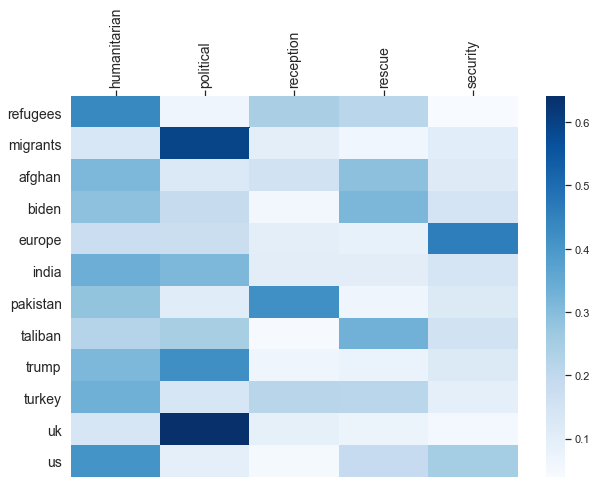

In [20]:
framed_entities = load_pickle('afghanistan_framed_entities')
aggr_frames, aggr_frames_pct = aggregate_frames(framed_entities)
frame_heatmap(aggr_frames_pct,'afghanistan')

## 5. Find frames timeline - frame variations over weeks

Pre-requisite files:

     - event_ents = list of entities (top 10 selected)
     - framed_entities = dataframe of all framing instances in an event dataset

In [10]:
import matplotlib.cm

cmap = matplotlib.cm.get_cmap('Set3')

# assigning the same color for a frame if it occurs across events
list_of_frames = 'humanitarian economic political security military criminal reception assault migration violence integration relief'.split(' ')
list_of_frames2 = 'xx xx military/political rescue xx xx xx assault xx annihilation vulnerability'.split(' ')
colormap = {list_of_frames[i]:cmap(i,bytes=False) for i in range(len(list_of_frames))}
colormap = {**colormap,  **{list_of_frames2[i]:cmap(i,bytes=False) for i in range(len(list_of_frames2))}}

In [11]:
def weekly_frames(entity,framed_entities,event_name):
    import matplotlib.patheffects as pe
    import numpy as np

    merged_frames = framed_entities.copy()
    merged_frames = merged_frames[merged_frames['entity'] == entity]
    #print(merged_frames)
    merged_frames['week'] = pd.to_datetime(merged_frames['date'], format='%Y-%m-%d').dt.strftime('%W')

    aggr_frames = merged_frames.groupby(['entity','week'],as_index=False).count()
    
    aggr_frames.drop(['entity','framing_word','date','tweet_id'],axis=1,inplace=True)
    
    aggr_frames = aggr_frames.set_index('week').T

    counts= aggr_frames.sum()
    aggr_frames = aggr_frames / aggr_frames.sum()
    
    tps = aggr_frames.T.div(aggr_frames.T.sum(1), axis=0)
    
    
    ax = tps.plot(kind='bar', stacked=True,color = colormap)#color = colors.values())#)
    ax2 = counts.plot(kind='line',lw=2,c='b',secondary_y=True,path_effects=[pe.Stroke(linewidth=4, foreground='w'), pe.Normal()])
    ax2.grid(False)
    ax.set_xlabel('week', fontsize=14)
    #ax.set(ylabel='% Frame proportion')
    #ax2.set(ylabel='Total frame instances')
    handles, labels = ax.get_legend_handles_labels()
    
    legend = ax.legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1.2, 0.5))
    #ax.legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1.2, 0.5))
    ax.set(ylabel=None)
    ax.tick_params(axis='both', labelsize=14)
    ax2.tick_params(axis='both', labelsize=14)
    #ax.set_title(f'{entity}', fontdict={'fontsize': 14, 'fontweight': 'medium'})
     
    
    def export_legend(legend, filename=f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_legend.png', expand=[-5,-5,5,5]):
        fig  = legend.figure
        fig.canvas.draw()
        bbox  = legend.get_window_extent()
        bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
        bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(filename, dpi="figure", bbox_inches=bbox)

    export_legend(legend)
    ax.get_legend().remove()
    figure = ax.get_figure()   
    figure.savefig(f'C:/Users/nikodemicek/Dropbox (CBS)/Master thesis data/Figs/{event_name}_{entity}_frames.png', 
                   dpi=600,
                   bbox_inches="tight")

    return aggr_frames



In [ ]:
event_name = 'greece'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:10]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)

In [ ]:
event_name = 'channel'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:9]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)

In [ ]:
event_name = 'tigray'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:10]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)

In [ ]:
event_name = 'rohingya'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:10]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)

['refugees', 'migrants', 'afghan', 'taliban', 'us', 'biden', 'uk', 'pakistan', 'india', 'trump', 'europe', 'turkey']


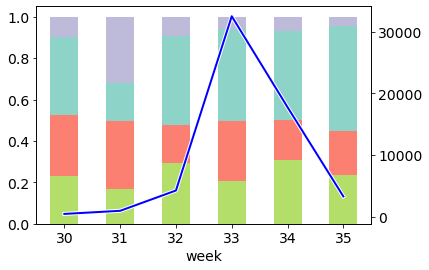

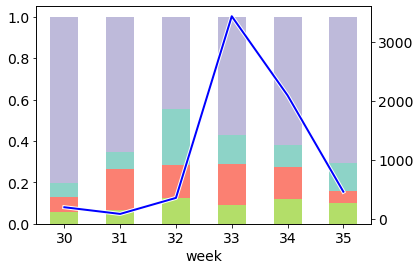

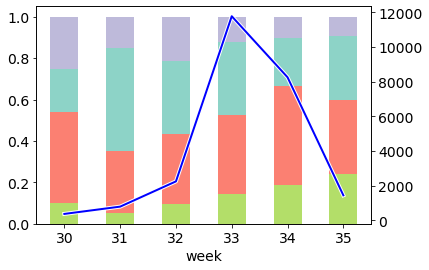

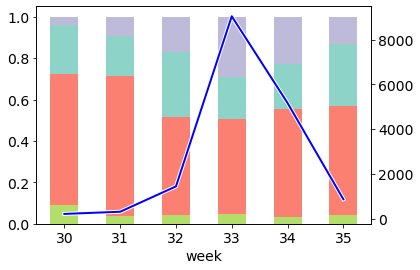

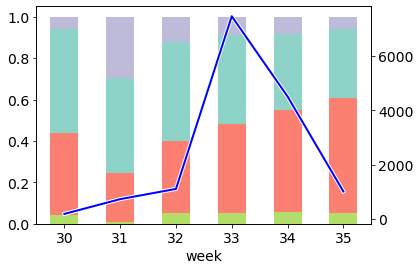

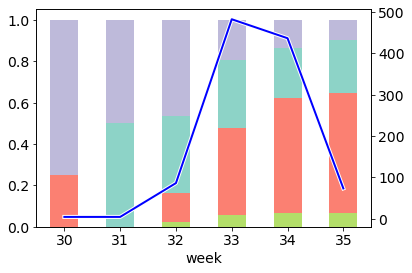

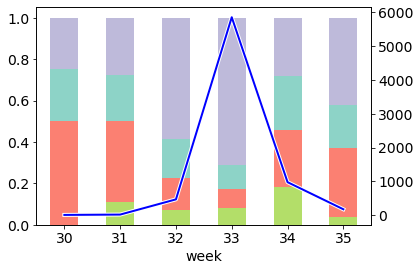

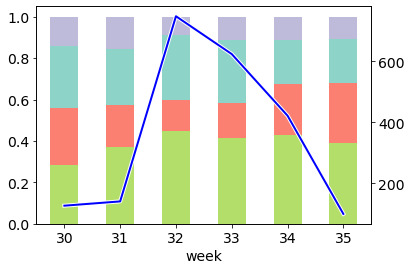

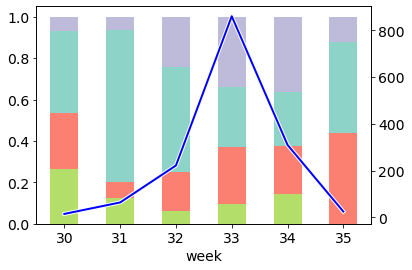

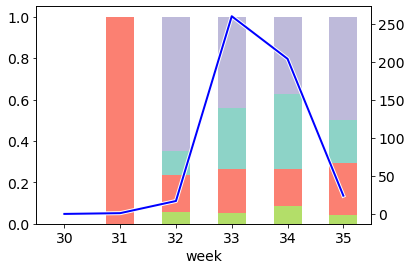

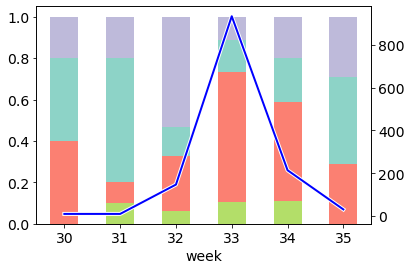

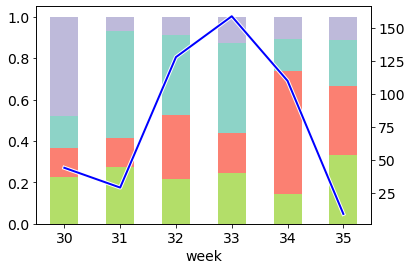

In [12]:
event_name = 'afghanistan'
event_ents = load_pickle(f'{event_name}_what_merged')
framed_entities = load_pickle(f'{event_name}_framed_entities')
entities = ['refugees','migrants'] + list(event_ents.keys())[:10]
print(entities)
for entity in entities:
    weekly_frames(entity,framed_entities,event_name)